# Tutorial

## Simple pendulum: build a surrogate model

In this tutorial we build a surrogate model for the damped simple pendulum using Arby. The physical setting is shown below.

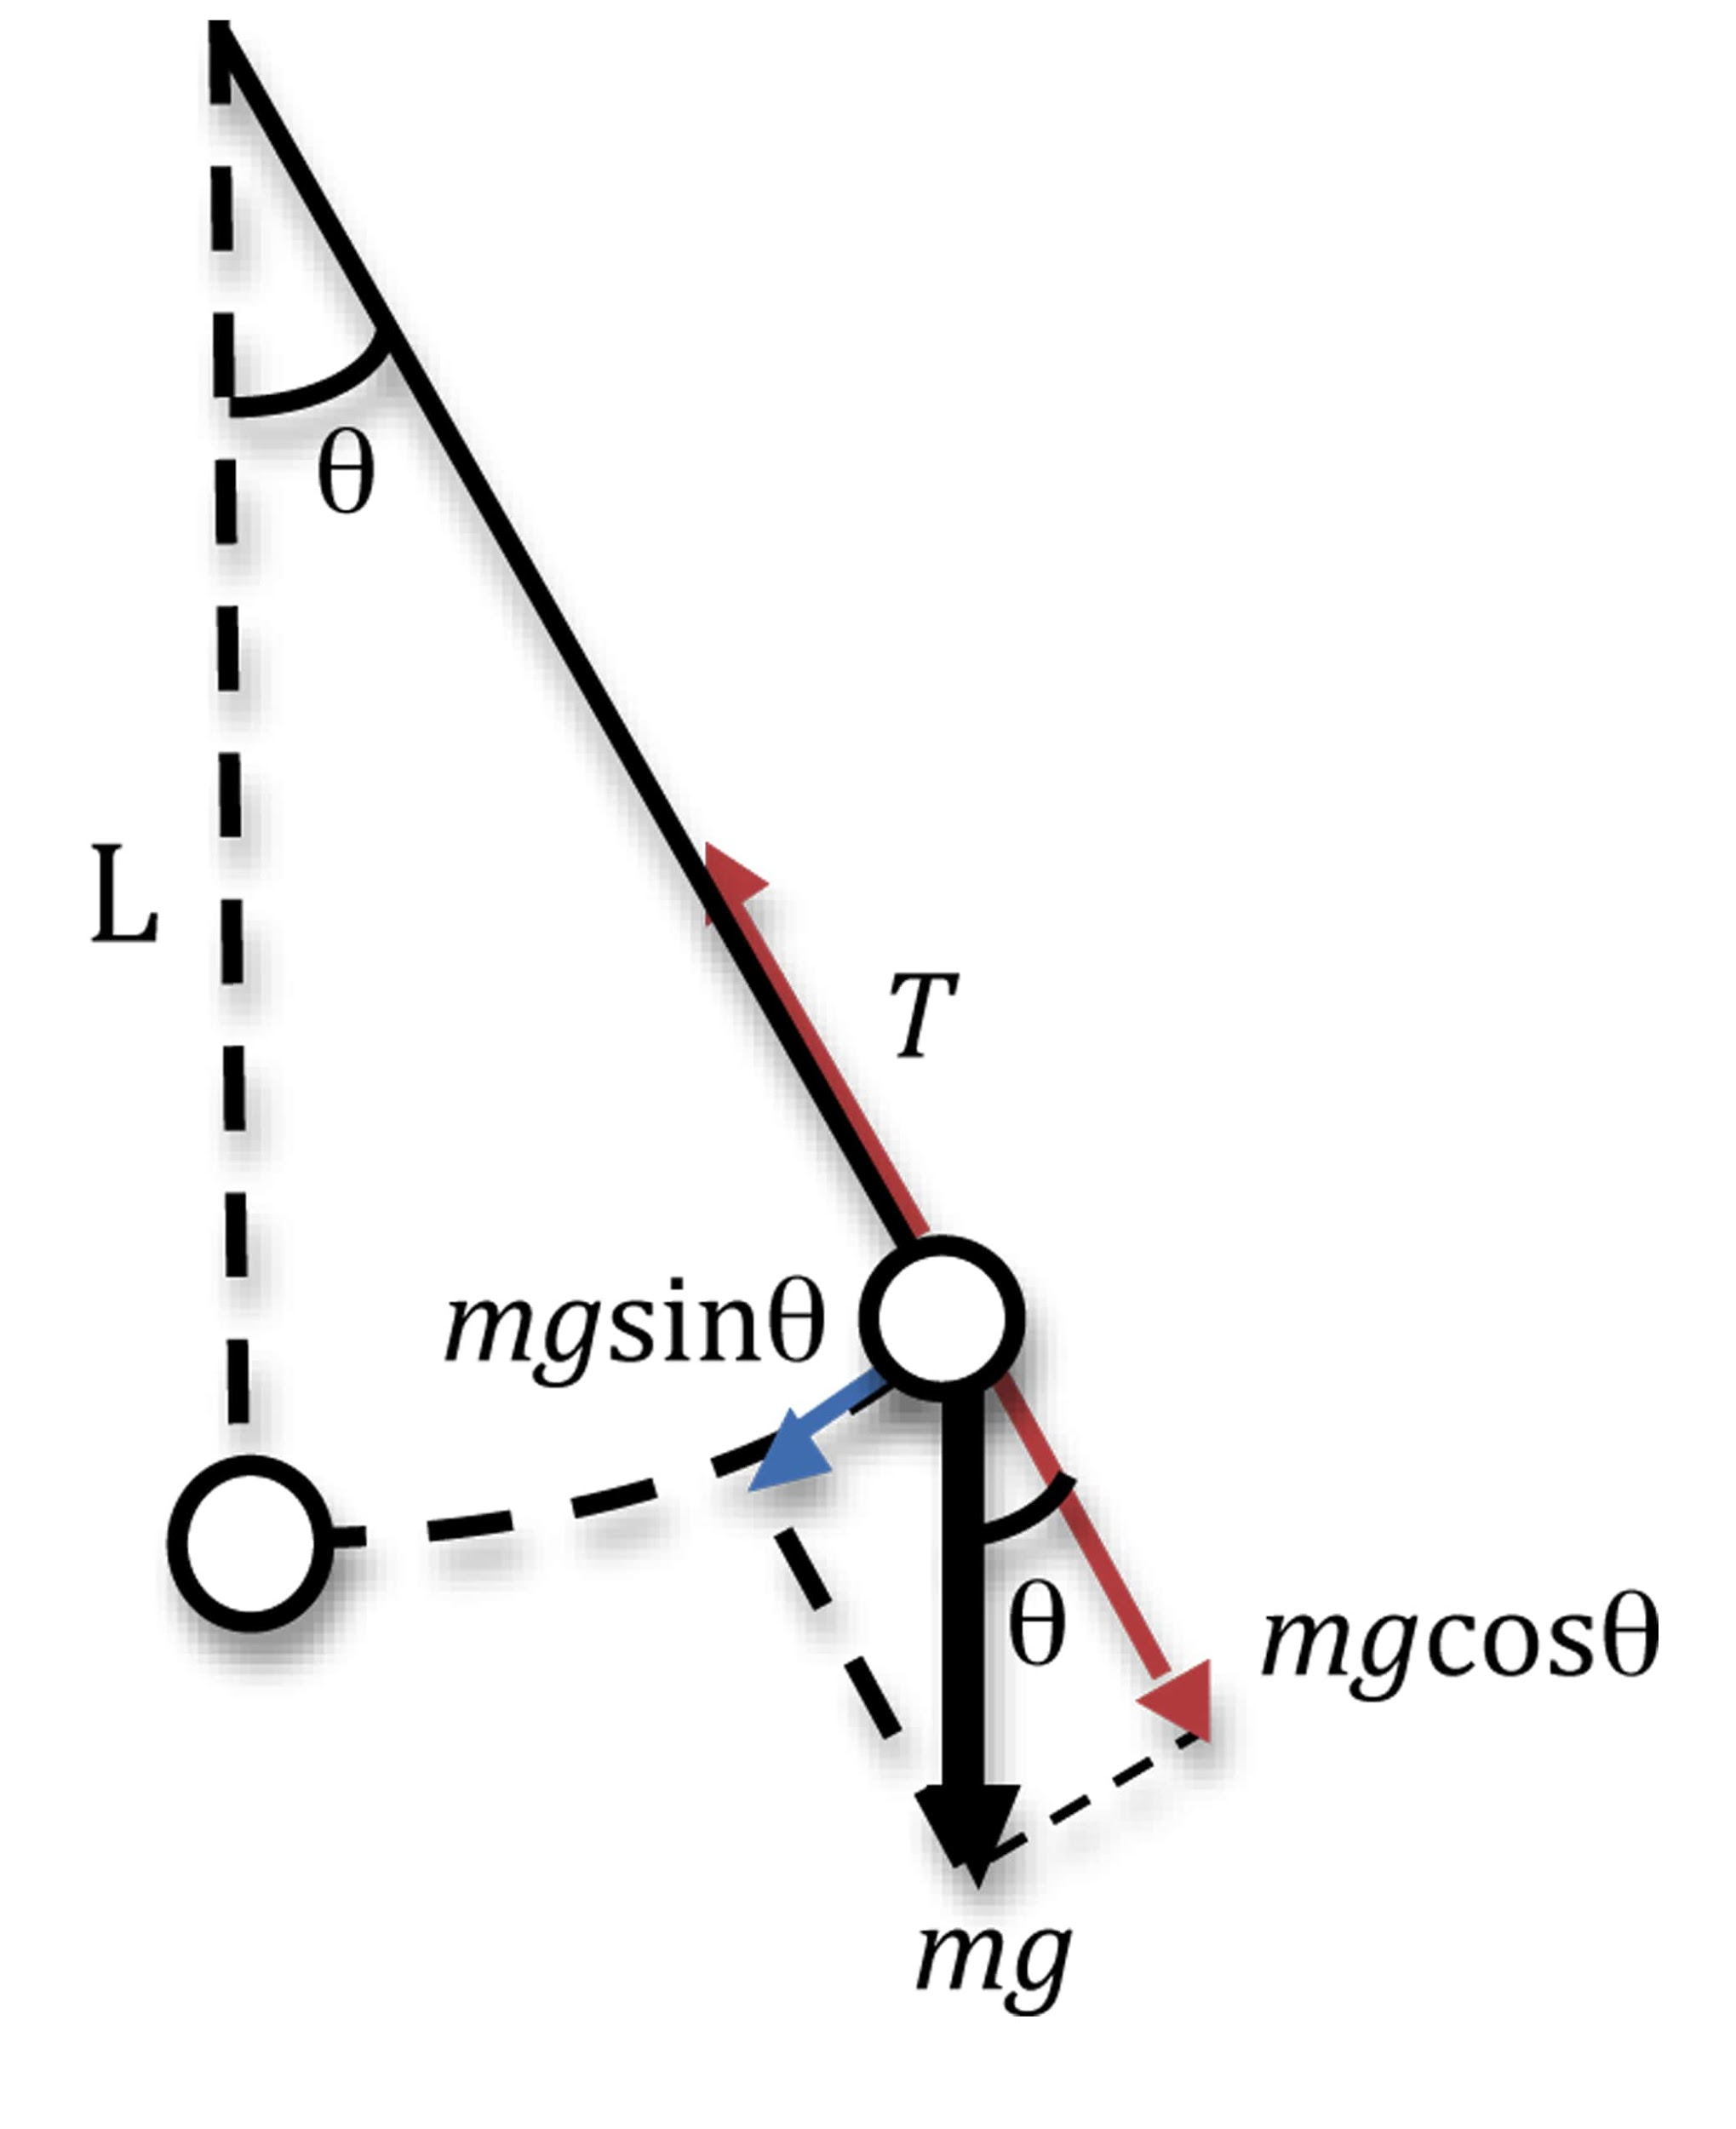

This system can be described by the ordinary differential equation (ODE)

\begin{equation}
\ddot{\theta} = -b\dot{\theta} - \frac{g}{l} \sin{\theta}
\end{equation}

where $g, l$ denote the gravity strenght and the pendulum longitude, respectively. The parameter $b$ is the damping factor.

We can decompose the 2nd order ODE above in two 1st order ODEs leading to the
desired pendulum equations

\begin{align}
\dot{\theta} &= \omega \\
\dot{\omega} &= -b \omega - \lambda \sin{\theta}
\end{align}

### Solving the pendulum equations

We import first some Python packages for handling and visualizing data.

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

Also we need an ODE solver. We use a module from the SciPy Python package.

In [4]:
from scipy.integrate import odeint

Let's define the ODE system and fix some initial conditions

In [5]:
def pend(y, t, b, λ):
    θ, ω = y
    dydt = [ω, -b*ω - λ*np.sin(θ)]

    return dydt

In [6]:
# set friction strength
b = 0.2
# set initial conditions
y0 = [np.pi/2, 0.]

In [7]:
# set a time discretization
times = np.linspace(0,50,1001)

In [8]:
# plot a simple solution
λ = 1.
sol = odeint(pend,y0, times, (b,λ))

Lets see how a solution looks

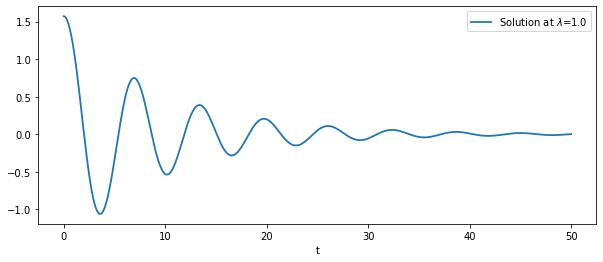

In [9]:
plt.figure(figsize=(10,4))
plt.plot(times, sol[:,0], label=f'Solution at $\lambda$={λ}', lw=1.8)
plt.xlabel('t')
plt.legend()

### Building the surrogate

Import the Arby main class for building surrogates

In [11]:
from arby import ReducedOrderModel as ROM

and define a discretization of the parametric domain. We chose the domain for $\lambda$ as $[1, 5]$ and a discretization of $101$ points.

In [15]:
param = np.linspace(1,5,101)

Lets build a training set.

In [16]:
training = []
for λ in param:
    sol = odeint(pend,y0, times, (b,λ))
    training.append(sol[:,0])

So far we have the main ingredients for building a surrogate for the pendulum system. Finally, create a pendulum model as a ROM object

In [17]:
pendulum = ROM(training, times, param, greedy_tol=1e-14, poly_deg=5)

and simply call/build the surrogate for some parameter value

In [18]:
pendulum.surrogate(1.14)

array([ 1.57079633,  1.56937605,  1.56513412, ..., -0.00282289,
       -0.00331644, -0.00379569])

That's all! We built a surrogate model for pendulum solutions. Now, for the sake of brevity, name the surrogate function.

In [19]:
surr = pendulum.surrogate

We want the surrogate to produce predictions. So lets look for an out-of-sample parameter to build a prediction.

In [20]:
param

array([1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 ,
       1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72, 1.76, 1.8 , 1.84,
       1.88, 1.92, 1.96, 2.  , 2.04, 2.08, 2.12, 2.16, 2.2 , 2.24, 2.28,
       2.32, 2.36, 2.4 , 2.44, 2.48, 2.52, 2.56, 2.6 , 2.64, 2.68, 2.72,
       2.76, 2.8 , 2.84, 2.88, 2.92, 2.96, 3.  , 3.04, 3.08, 3.12, 3.16,
       3.2 , 3.24, 3.28, 3.32, 3.36, 3.4 , 3.44, 3.48, 3.52, 3.56, 3.6 ,
       3.64, 3.68, 3.72, 3.76, 3.8 , 3.84, 3.88, 3.92, 3.96, 4.  , 4.04,
       4.08, 4.12, 4.16, 4.2 , 4.24, 4.28, 4.32, 4.36, 4.4 , 4.44, 4.48,
       4.52, 4.56, 4.6 , 4.64, 4.68, 4.72, 4.76, 4.8 , 4.84, 4.88, 4.92,
       4.96, 5.  ])

We choose `par = 3.42`. Now compare prediction and true solution.

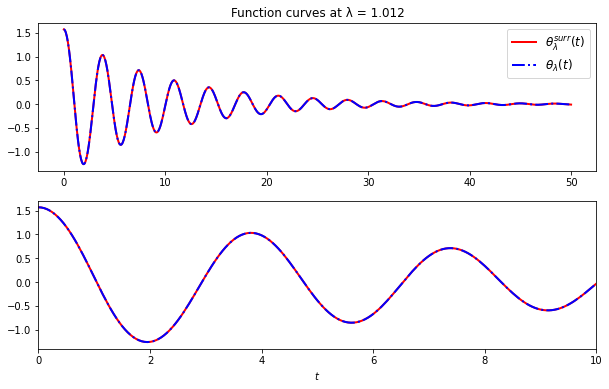

In [21]:
par = 3.42
sol = odeint(pend,y0, times, (b,par))[:,0]
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(times, surr(par), 'r', lw=2, label='$θ_λ^{surr}(t)$')
ax[0].plot(times, sol, 'b-.', lw=2, label='$θ_λ(t)$')
ax[1].plot(times, surr(par), 'r', lw=2, label='$θ_λ^{surr}(t)$')
ax[1].plot(times, sol, 'b-.', lw=2, label='$θ_λ(t)$')
ax[1].set(xlim=(0,10))
ax[1].set(xlabel='$t$')
ax[0].set_title('Function curves at λ = 1.012')
ax[0].legend(fontsize = 'large')

Nice! At least they match at eyeball resolution. How fast is it with respect to solving the whole ODE system for some parameter?

To respond that we perform a simple profiling for evaluating computation times for both, surrogate and ODE solver

In [22]:
λ = 2.17
%timeit -t sol = odeint(pend,y0, times, (b,λ))

5.84 ms ± 389 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%timeit -t pendulum.surrogate(λ)

1.41 ms ± 95.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


 The surrogate is $\sim 4$ times faster than solving the ODE system.

### Benchmarks

We'd like to quantify the accuracy of the surrogate. To this, we perform a benchmark measuring the $L_2$ relative error between the surrogate and a dense validation or test set of true solutions

$$
e(\lambda)^2 := \frac{\|\theta^{surr}_\lambda - \theta_\lambda^{true}\|^2}{\|\theta^{true}_\lambda\|^2}
$$

where

$$
\|\theta\|^2 := \int \theta^2(t) dt
$$

In [25]:
# name the norm tool from the integration object
norm = pendulum.basis_.integration.norm
# create a dense validation set (10x the size of the training set)
param_val = np.linspace(1,5,1001)
# compute errors
errors = []
for λ in param_val:
    sol = odeint(pend,y0, times, (b,λ))[:,0]
    errors.append(norm(sol - surr(λ))/norm(sol))

Plot the errors

Text(0.5, 1.0, 'Validation errors')

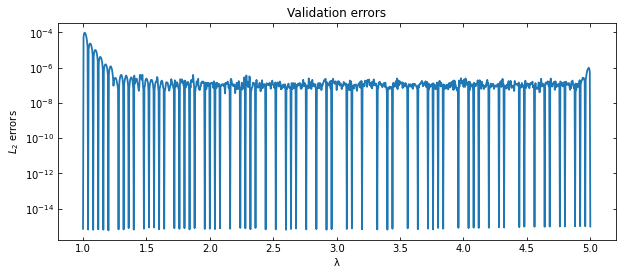

In [26]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(param_val, errors, lw=1.8)
ax.set_yscale('log')
ax.yaxis.set_ticks_position('both')
ax.tick_params(direction='in', which='both')
ax.xaxis.set_ticks_position('both')
ax.set_xlabel('λ')
ax.set_ylabel('$L_2$ errors')
ax.set_title('Validation errors')

Which is the parameter corresponding to the largest error?

In [27]:
worst_lambda = param_val[np.argmax(errors)]

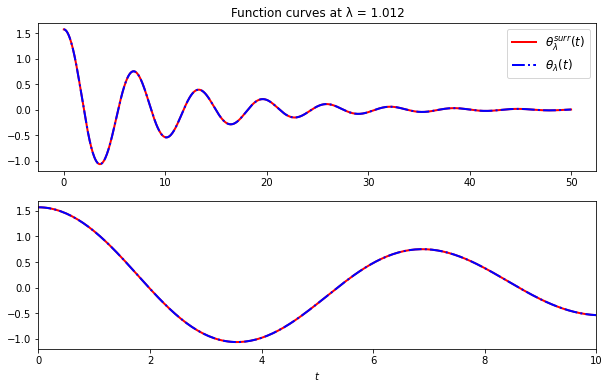

In [28]:
# plot the overlap between the surrogate and the true solution model
# at the worst parameter
par = worst_lambda
sol = odeint(pend,y0, times, (b,par))[:,0]
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(times, surr(par), 'r', lw=2, label='$θ_λ^{surr}(t)$')
ax[0].plot(times, sol, 'b-.', lw=2, label='$θ_λ(t)$')
ax[1].plot(times, surr(par), 'r', lw=2, label='$θ_λ^{surr}(t)$')
ax[1].plot(times, sol, 'b-.', lw=2, label='$θ_λ(t)$')
ax[1].set(xlim=(0,10))
ax[1].set(xlabel='$t$')
ax[0].set_title(f'Function curves at λ = {worst_lambda}')
ax[0].legend(fontsize = 'large')

The curves are indistinguishable to eyeball resolution even for the worst case scenario.

## Build a reduced basis

Lets go deeper. The Reduced Basis Method is a reduced order modeling technique for building a
near-optimal basis of functions that spans the training set at an user-specified tolerance. 
The basis is built by iteratively choosing those training functions which best represent the entire set.
In this way, as opposed to other dimensional reduction techniques such as Proper Orthogonal Decomposition,
the reduced basis is directly interpretable since it is built out from training functions. Another kindness
of this approach is that whenever we want more accuracy we just add more basis elements to the computed one:
the construction is hierarchical.

Suppose we have a training set $\{f_{\lambda_i}\}_{i=1}^N$ of parameterized real
functions. This set may represent a non-linear model, perhaps solutions to PDEs. We'd like, if possible, to reduce the dimensionality/complexity of it by finding a
compact representation in terms of linear combinations of basis elements
$\{e_i\}_{i=1}^n$, that is,

$$
f \approx \sum_{i=1}^n c_i e_i\,.
$$

f is an arbitrary training function and the $c_i$'s are the projection coefficients
$<e_i,f>$ computed in some inner product $<\cdot,\cdot>$ on the space of functions.
The RB method chooses a set of optimal functions belonging to the training set itself which defines a
finite dimensional subspace capable to represent the entire training set up to a user-specified tolerance.

To build a reduced basis with Arby, you just provide the training set of functions and the
discretization of the physical variable $x$ to the ``reduced_basis`` function.
The later is to define the integration scheme that is used for computing inner products. For the
pendulum example,

In [ ]:
from arby import reduced_basis

rb_data = reduced_basis(training_set=training,
                        physical_points=times, greedy_tol=1e-12)

The ``greedy_tol`` parameter is the accuracy in the $L_2$-norm that our
reduced basis is expected to achieve. The output ``rb_data`` contains all the relevant information
related to greedy calculations. It contains a ``basis`` object which comprises the reduced basis and several
utilities for interacting with it. The other outputs are the greedy ``errors`` and ``indices``,
and the ``projection_matrix``, which stores projection coefficients built in the greedy algorithm.
For example, to call the reduced basis array do

In [ ]:
rb_data.basis.data

The reduced basis is an orthonormalized version of the set of functions selected by the
greedy algorithm and indexed by the greedy indices. You can obtain
those functions by filtering the training set

In [ ]:
training_set[rb_data.indices]

For conditioning purposes, the greedy algorithm orthonormalizes the basis.

The number of basis elements ``rb_data.basis.Nbasis_`` represents the dimension of the reduced space.
It is not a fixed quantity since we can change it by modifying the greedy tolerance. The lower the tolerance, the bigger the number of basis elements needed to reach that accuracy. With Arby, we can tune the reduced basis accuracy through the ``greedy_tol`` parameter.

To quantify the representation effectiveness of the reduced basis to approximate a solution `f`, we can compute the norm of the difference between a training function `f` and its
projected version using the tools coming inside the ``rb_data.basis`` class object.

In [ ]:
projected_f = rb_data.basis.project(f)
norm = rb_data.basis.integration.norm
L2_error = norm(f - projected_f)

Or take a shortcut by doing

In [ ]:
projection_error = rb_data.basis.projection_error
squared_L2_error = projection_error(f)

The output is the square version of the error computed in the previous code block.

## Further reading

- This package was built upon previous work developed in the field of Gravitational Wave (GW) science. Important papers are
    - [Reduced basis catalogs for gravitational wave templates](https://doi.org/10.1103/PhysRevLett.106.221102)
    - [Towards beating the curse of dimensionality for gravitational waves using Reduced Basis](https://doi.org/10.1103/PhysRevD.86.084046)
    - [Fast prediction and evaluation of gravitational waveforms using surrogate models](https://doi.org/10.1103/PhysRevX.4.031006)
- For some theoretical aspects on the Reduced Basis greedy algorithm and the Empirical Interpolation Method check
    - [Two-step greedy algorithm for reduced order quadratures](https://doi.org/10.1007/s10915-013-9722-z)
    - [A Note on QR-Based Model Reduction: Algorithm, Software, and Gravitational Wave Applications](https://arxiv.org/abs/1805.06124)
    - [On the stability and accuracy of the Empirical Interpolation Method and Gravitational Wave Surrogates](https://doi.org/10.1088/1361-6382/abf894)
- For a thorough review on Reduced Order Methods as implemented in this package, check
    - [Reduced Order and Surrogate Models for Gravitational Waves](https://arxiv.org/abs/2101.11608)
- For nice visuals on the application of surrogate modeling in GW Science check [this](https://vijayvarma392.github.io/SurrogateMovie/).